In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  6 11:37:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow import keras
import random
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage.transform  as sktf


DATA TRAINING LITS

In [ ]:
# path_train_list = []
# path_train_mask_list = []

# pathInputTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/ct/"
# pathMaskTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/label/"
# for instance_img in sorted(glob.iglob(pathInputTarget + "/*.npy")):
#   path_train_list.append(instance_img)

# for instance_mask in sorted(glob.iglob(pathMaskTarget + "/*.npy")):
#   path_train_mask_list.append(instance_mask)

In [ ]:
# print(len(path_train_list))
# print(len(path_train_mask_list))

6204
6204


In [ ]:
# pathInputTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/test/ct/"
# pathMaskTarget = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/test/label/"
# for instance_img in sorted(glob.iglob(pathInputTarget + "/*.npy")):
#   path_train_list.append(instance_img)

# for instance_mask in sorted(glob.iglob(pathMaskTarget + "/*.npy")):
#   path_train_mask_list.append(instance_mask)

In [ ]:
# print(len(path_train_list))
# print(len(path_train_mask_list))

6893
6893


In [ ]:
# print(path_train_list[6892])
# print(path_train_mask_list[0])

/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/test/ct/volume-46_slice_9.npy
/content/drive/MyDrive/Liver Segmentation/LTS_NewData/dataset/img_slice_128_new/train_val/label/segmentation-0_slice_0.npy


In [ ]:
# def checking_sortImage(path_image, path_label):
#   if(len(path_image) != len(path_label)):
#     print("len false")
#     return False
#   for index in range(0,len(path_image)):
#     strA = path_image[index]
#     strB = path_label[index]
#     strA = strA[strA.rfind("vol-")+4:]
#     strB = strB[strB.rfind("seg-")+4:]
#     #print(strA)
#     #print(strB)
#     if(strA != strB):
#       print("djfhgkjdhfgkjd")
#       return False
#   return True

In [6]:
import cv2
def rotate_image(ct, label):
  ct = cv2.rotate(ct, cv2.ROTATE_90_CLOCKWISE)
  label = cv2.rotate(label, cv2.ROTATE_90_CLOCKWISE)
  return ct, label

In [7]:
import cv2
def flip_image(ct, label):
  axis = random.randint(-1, 1)
  ct = cv2.flip(ct, axis)
  label = cv2.flip(label, axis)
  return ct, label

In [8]:
import random
w, h = 128, 128
batch_size = 16

# Dataset va Dataloader

# Dung de tao toan bo du lieu va load theo batch
class Dataset:
    def __init__(self, image_path, mask_path, w, h):
        # the paths of images
        self.image_path = image_path
        # the paths of segmentation images
        self.mask_path = mask_path

        self.w = w
        self.h = h

    def __getitem__(self, i):

        image = np.load(self.image_path[i])
        mask =  np.load(self.mask_path[i])
        return image, mask

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,shape, shuffle=False, data_transform=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.shape = shape
        self.indexes = np.arange(self.shape)
        self.data_transform = data_transform
        self.on_epoch_end()

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            if self.data_transform:
              num = random.randint(0, 1)
              #### original image
              # num = 0
              _image,_label = self.dataset[j]
              data.append((_image,_label))
              if num == 0:
                ### rotate image
                _image_RT, _label_RT = rotate_image(_image, _label)
                _image_RT = np.expand_dims(_image_RT, -1)
                _label_RT = np.expand_dims(_label_RT, -1)
                data.append((_image_RT,_label_RT))
              else:
                _image_FL, _label_FL = flip_image(_image, _label)
                _image_FL = np.expand_dims(_image_FL, -1)
                _label_FL = np.expand_dims(_label_FL, -1)
                data.append((_image_FL,_label_FL))
            else:
              _image,_label = self.dataset[j]
              data.append((_image,_label))

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [9]:
path_train_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Train/ct.txt"
path_train_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Train/label.txt"

path_validate_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Validate/ct.txt"
path_validate_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Validate/label.txt"

path_test_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/ct.txt"
path_test_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/label.txt"

In [10]:
# for read ct training dataset
image_train = []
with open(path_train_ct_txt, "r") as input:
    image_train = input.read().split(',')

In [11]:
print(len(image_train))

5514


In [12]:
# for read label training dataset
mask_train = []
with open(path_train_label_txt, "r") as input:
    mask_train = input.read().split(',')

In [13]:
print(len(mask_train))

5514


In [13]:
# for read ct validate dataset
image_validate = []
with open(path_validate_ct_txt, "r") as input:
    image_validate = input.read().split(',')

print(len(image_validate))

689


In [14]:
# for read label validate dataset
mask_validate = []
with open(path_validate_label_txt, "r") as input:
    mask_validate = input.read().split(',')

print(len(mask_validate))

689


In [15]:
# from sklearn.model_selection import train_test_split
# image_train, image_validate, mask_train, mask_validate = train_test_split(path_train_list, path_train_mask_list, test_size=0.2,random_state= 45)
# image_validate, image_test, mask_validate, mask_test = train_test_split(image_validate, mask_validate, test_size=0.5,random_state= 45)

train_dataset = Dataset(image_train, mask_train, w, h)
validate_dataset = Dataset(image_validate, mask_validate, w, h)
# test_dataset = Dataset(image_test, mask_test, w, h)

train_loader = Dataloader(train_dataset, batch_size, shape=len(image_train), shuffle=True, data_transform=True)
validate_loader = Dataloader(validate_dataset, batch_size, shape=len(image_validate), shuffle=True, data_transform=True)

train_steps = len(image_train)//batch_size
valid_steps = len(image_validate)//batch_size

x, y = train_loader.__getitem__(1)
print(x.shape, y.shape)
print(len(image_train))
#print(len(image_test))
print(len(image_validate))
#print(len(path_test_mask_list))
#print(len(image_test))
#print(len(mask_test))

(32, 128, 128, 1) (32, 128, 128, 1)
5514
689


In [ ]:
# for ct training dataset and label training
# with open(path_train_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_train)):
#         if(index != (len(image_train)-1)):
#           strr = image_train[index] +","
#         else:
#           strr = image_train[index]
#         output.write(strr)


# with open(path_train_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_train)):
#       if(index != (len(mask_train)-1)):
#         strr = mask_train[index] +","
#       else:
#         strr = mask_train[index]
#       output.write(strr)

In [ ]:
# for ct validate dataset and label validate
# with open(path_validate_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_validate)):
#         if(index != (len(image_validate)-1)):
#           strr = image_validate[index] +","
#         else:
#           strr = image_validate[index]
#         output.write(strr)


# with open(path_validate_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_validate)):
#         if(index != (len(mask_validate)-1)):
#           strr = mask_validate[index] +","
#         else:
#           strr = mask_validate[index]
#         output.write(strr)

In [ ]:
# for ct test dataset and label test
# with open(path_test_ct_txt, "w") as output:
#     strr =""
#     for index in range(len(image_test)):
#         if(index != (len(image_test)-1)):
#           strr = image_test[index] +","
#         else:
#           strr = image_test[index]
#         output.write(strr)


# with open(path_test_label_txt, "w") as output:
#     strr =""
#     for index in range(len(mask_test)):
#         if(index != (len(mask_test)-1)):
#           strr = mask_test[index] +","
#         else:
#           strr = mask_test[index]
#         output.write(strr)


#Model

In [14]:
def ConvBlock(filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               activation=None,
               kernel_initializer='he_uniform',
               dropout=None,
               use_batchnorm=True):
    def wrapper(input_tensor):
        conv = layers.Conv2D(filters=filters,
                             kernel_size=kernel_size,
                             strides=(1, 1),
                             padding=padding,
                             kernel_initializer=kernel_initializer
                            )(input_tensor)
        if use_batchnorm:
            conv = layers.BatchNormalization()(conv)
        if activation:
            conv = layers.Activation(activation)(conv)

        conv = layers.Conv2D(filters=filters,
                             kernel_size=kernel_size,
                             strides=(1, 1),
                             padding=padding,
                             kernel_initializer=kernel_initializer
                            )(conv)
        if use_batchnorm:
            conv = layers.BatchNormalization()(conv)
        if activation:
            conv = layers.Activation(activation)(conv)

        if 0 < dropout <= 1:
            conv = layers.Dropout(dropout)(conv)
        return conv

    return wrapper


def AttentionBlock(inter_filters,name=None):
    def wrapper(x,gating):
        shape_x = K.int_shape(x)        # (1, 128, 128, 128)
        shape_g = K.int_shape(gating)   # (1, 64, 64, 64)

        theta_x = layers.Conv2D(inter_filters,(2,2),strides=(2,2),padding='same')(x)    # (1, 64, 64, 128)
        phi_g   = layers.Conv2D(inter_filters,(1,1),padding='same')(gating) # (1, 64, 64, 128)

        concate_xg  = layers.add([theta_x,phi_g])   # (1, 64, 64, 128)
        relu_xg     = layers.Activation('relu')(concate_xg) # (1, 64, 64, 128)
        psi         = layers.Conv2D(1,(1,1),padding='same')(relu_xg)    # (1, 64, 64, 1)
        sigmoid_xg  = layers.Activation('sigmoid')(psi) # (1, 64, 64, 1)
        up_psi      = layers.UpSampling2D((shape_x[1]//shape_g[1],shape_x[2]//shape_g[2]),
                                          name=f'{name}_coefficient' if name else None)(sigmoid_xg)  # (1, 128, 128, 1)
        up_psi      = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                            arguments={'repnum': shape_x[3]})(up_psi)   # (1, 128, 128, 128)
        y = layers.multiply([up_psi, x])    # (1, 128, 128, 128)

        result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)   # (1, 128, 128, 128)
        result_bn = layers.BatchNormalization(name=name)(result) # (1, 128, 128, 128)

        return result_bn

    return wrapper


def TritentionBlock(inter_filters,name=None):
    def wrapper(x,lower_gate, upper_gate):
        shape_x = K.int_shape(x)
        shape_lg = K.int_shape(lower_gate)
        shape_ug = K.int_shape(upper_gate)

        theta_x = layers.Conv2D(inter_filters, kernel_size=(1,1), strides=(1,1), padding='same')(x)
        phi_lg  = layers.Conv2DTranspose(inter_filters, kernel_size=(1,1), strides=(2,2), padding='same')(lower_gate)
        phi_ug  = layers.Conv2D(inter_filters, kernel_size=(2,2), strides=(2,2), padding='same')(upper_gate)

        concate_xlg = layers.add([theta_x, phi_lg])
        concate_xug = layers.add([theta_x, phi_ug])

        relu_xlg    = layers.Activation('relu')(concate_xlg)
        relu_xug    = layers.Activation('relu')(concate_xug)

        conv_xlg    = layers.Conv2D(inter_filters/2, kernel_size=(1,1), strides=(1,1), padding='same')(relu_xlg)
        conv_xug    = layers.Conv2D(inter_filters/2, kernel_size=(1,1), strides=(1,1), padding='same')(relu_xug)

        concate_xlu = layers.add([conv_xlg, conv_xug])
        relu_xlu    = layers.Activation('relu')(concate_xlu)
        conv_xlu    = layers.Conv2D(1, kernel_size=(1,1), strides=(1,1), padding='same')(relu_xlu)
        sigmoid_xlu = layers.Activation('sigmoid', name=f'{name}_coefficient' if name else None)(conv_xlu)
        up_xlu      = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                            arguments={'repnum': shape_x[-1]})(sigmoid_xlu)
        y = layers.multiply([up_xlu, x])

        result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
        result_bn = layers.BatchNormalization(name=name)(result)

        return result_bn

    return wrapper
DEPTH = 4

def TritentionUNet(input_shape,num_classes=1,dropout_rate=0.0,batch_norm=True,activation='relu',name='tri_unet'):
    features = 64
    skip_connections = []

    inputs = layers.Input(input_shape)
    x = inputs

    # Downsampling layers
    for i in range(DEPTH):
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
        skip_connections.append(x)
        x = layers.MaxPool2D((2,2))(x)
        features = features*2

    # Bottom layers
    x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
    skip_connections.append(x)

    # Upsampling layers
    for i in reversed(range(DEPTH)):
        features = features/2
        if i != 0:
            att = TritentionBlock(features,name='tritention_'+str(i))(skip_connections[i],skip_connections[i+1],skip_connections[i-1])
        else:
            att = AttentionBlock(features,name='attention_'+str(i))(skip_connections[i],skip_connections[i+1])

        x = layers.Conv2DTranspose(features,(2,2),strides=(2,2),padding='same')(x)
        x = layers.Activation(activation)(x)
        x = layers.concatenate([x, att], axis=-1)
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)

    # Model head
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1),padding='same')(x)
    if batch_norm:
        conv_final = layers.BatchNormalization(axis=-1)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    model = keras.models.Model(inputs, conv_final, name=name)

    return model


def UNet(input_shape,num_classes=1,dropout_rate=0.0,batch_norm=True,activation='relu',name='unet'):
    features = 64
    skip_connections = []

    inputs = layers.Input(input_shape)
    x = inputs

    # Downsampling layers
    for i in range(DEPTH):
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
        skip_connections.append(x)
        x = layers.MaxPool2D((2,2))(x)
        features = features*2

    # Bottom layers
    x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)

    # Upsampling layers
    for i in reversed(range(DEPTH)):
        features = features/2
        x = layers.Conv2DTranspose(features,(2,2),strides=(2,2),padding='same')(x)
        x = layers.Activation(activation)(x)
        x = layers.concatenate([x, skip_connections[i]], axis=-1)
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)

    # Model head
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1),padding='same')(x)
    if batch_norm:
        conv_final = layers.BatchNormalization(axis=-1)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    model = keras.models.Model(inputs, conv_final, name=name)

    return model

def TP_UNet(input_shape,num_classes=1,dropout_rate=0.0,batch_norm=True,activation='relu',name='para_unet'):
    features = 64
    skip_connections = []
    #paramid_down = []
    paramid_up = []
    paramid_down = []
    futures_paramid_up = []
    futures_paramid_down = []
    inputs = layers.Input(input_shape)
    x = inputs

    # Downsampling layers
    for i in range(DEPTH):
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
        skip_connections.append(x)
        paramid_down.append(x)
        futures_paramid_down.append(features)
        x = layers.MaxPool2D((2,2))(x)
        features = features*2

    # Bottom layers
    x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
    skip_connections.append(x)

    # Upsampling layers
    for i in reversed(range(DEPTH)):
        features = features/2
        if i != 0:
            att = TritentionBlock(features,name='tritention_'+str(i))(skip_connections[i],skip_connections[i+1],skip_connections[i-1])
        else:
            att = AttentionBlock(features,name='attention_'+str(i))(skip_connections[i],skip_connections[i+1])

        x = layers.Conv2DTranspose(features,(2,2),strides=(2,2),padding='same')(x)
        x = layers.Activation(activation)(x)
        x = layers.concatenate([x, att], axis=-1)
        x = ConvBlock(features,(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(x)
        paramid_up.append(x)
        futures_paramid_up.append(features)

    # Handle paramid in midle of process.
    xm = layers.Conv2D(futures_paramid_down[len(futures_paramid_down) - 1], kernel_size=(1,1),padding='same')(paramid_down[len(futures_paramid_down) - 1])
    for index in reversed(range(len(futures_paramid_down) - 1)):
        _xm = layers.Conv2D(futures_paramid_down[index], kernel_size=(1,1),padding='same')(paramid_down[index])
        xm = layers.Conv2DTranspose(futures_paramid_down[index],(2,2),strides=(2,2),padding='same')(xm)
        xm = layers.Add()([xm, _xm])

    # Handle paramid in end of process.
    xe = layers.Conv2D(futures_paramid_up[0], kernel_size=(1,1),padding='same')(paramid_up[0])
    for index in range(1,len(paramid_up)):
        _xe = layers.Conv2D(futures_paramid_up[index], kernel_size=(1,1),padding='same')(paramid_up[index])
        xe = layers.Conv2DTranspose(futures_paramid_up[index],(2,2),strides=(2,2),padding='same')(xe)
        xe = layers.Add()([xe, _xe])

    xm = ConvBlock(futures_paramid_down[0],(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(xm)
    xe = ConvBlock(futures_paramid_down[0],(3,3),padding='same',activation=activation,dropout=dropout_rate,use_batchnorm=batch_norm)(xe)
    conv_final = layers.concatenate([x, xm], axis=-1)
    conv_final = layers.concatenate([conv_final, xe], axis=-1)
    # Model head
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1),padding='same')(conv_final)
    if batch_norm:
        conv_final = layers.BatchNormalization(axis=-1)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    model = keras.models.Model(inputs, conv_final, name=name)

    return model

# Metrics

In [15]:
from sklearn.metrics import confusion_matrix
SMOOTH = 1e-5

def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    if K.image_data_format() == 'channels_last':
        x = K.permute_dimensions(x, (3, 0, 1, 2))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = K.permute_dimensions(x, (1, 0, 2, 3))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 0, 2, 3))
    return

def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs

def get_reduce_axes(per_image, **kwargs):
    axes = [1, 2] if K.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes

def round_if_needed(x, threshold, **kwargs):
    if threshold is not None:
        x = K.greater(x, threshold)
        x = K.cast(x, K.floatx())
    return x


def average(x, per_image=False, class_weights=None, **kwargs):
    if per_image:
        x = K.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return K.mean(x)


def dice_loss(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5,
            **kwargs):
    r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:
    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        F-score in range [0, 1]
    """


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return 1 - score
def dice_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5,
            **kwargs):
    r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:
    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}
    The formula in terms of *Type I* and *Type II* errors:
    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}
    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round
    Returns:
        F-score in range [0, 1]
    """


    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def binary_focal_loss(gt, pr, gamma=2.0, alpha=0.25, **kwargs):
    r"""Implementation of Focal Loss from the paper in binary classification
    Formula:
        loss = - gt * alpha * ((1 - pr)^gamma) * log(pr) \
               - (1 - gt) * alpha * (pr^gamma) * log(1 - pr)
    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        alpha: the same as weighting factor in balanced cross entropy, default 0.25
        gamma: focusing parameter for modulating factor (1-p), default 2.0
    """

    # clip to prevent NaN's and Inf's
    pr = K.clip(pr, K.epsilon(), 1.0 - K.epsilon())

    loss_1 = - gt * (alpha * K.pow((1 - pr), gamma) * K.log(pr))
    loss_0 = - (1 - gt) * ((1 - alpha) * K.pow((pr), gamma) * K.log(1 - pr))
    loss = K.mean(loss_0 + loss_1)
    return loss


def binary_focal_dice_loss(gt, pr, gamma=2.0, alpha=0.25, beta=1, class_weights=1,
                        class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5, **kwargs):

    # dice loss
    dloss = dice_loss(
                    gt,
                    pr,
                    beta=beta,
                    class_weights=class_weights,
                    class_indexes=class_indexes,
                    smooth=smooth,
                    per_image=per_image,
                    threshold=threshold
                )

    # binary focal dice loss
    floss = binary_focal_loss(gt, pr, alpha=alpha, gamma=gamma)
    return dloss + floss

def RVD(gt, pr, gamma=2.0, alpha=0.25, beta=1, class_weights=1,class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5, **kwargs):
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)

    t_gt = K.sum(gt)
    t_pr = K.sum(pr)
    score = ((t_pr+smooth)/(t_gt+smooth) - 1)
    score = average(score, per_image, class_weights, **kwargs)
    return score


def RVD(gt, pr, gamma=2.0, alpha=0.25, beta=1, class_weights=1,class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5, **kwargs):
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)

    t_gt = K.sum(gt)
    t_pr = K.sum(pr)
    score = ((t_pr+smooth)/(t_gt+smooth) - 1)
    score = average(score, per_image, class_weights, **kwargs)
    return score

def VOE(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=0.5,
            **kwargs):
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp
    score = (1. - ( (float(tp) + smooth)/(float(tp+fp+fn) + smooth)))
    score = average(score, per_image, class_weights, **kwargs)
    return score

#MODEL

In [18]:
#Training Paramid Tritention Unet
opt=tf.keras.optimizers.Adam(0.0001)
input_shape = (128,128,1)
model= TP_UNet(input_shape);
model.compile(optimizer=opt,loss=[binary_focal_dice_loss],metrics=[dice_score,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath1 = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Weight/1_TPUnet_best.hdf5"
filepath2 = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Weight/1_TPUnet_end.hdf5"
callback1 = ModelCheckpoint(filepath1, monitor='val_dice_score', verbose=1, save_best_only=True,mode='max')
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history  = model.fit_generator(train_loader, validation_data=validate_loader, epochs=100, callbacks = [callback1,callback2])
model.save_weights(filepath2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<ipython-input-19-22de0acc01e3>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history  = model.fit_generator(train_loader, validation_data=validate_loader, epochs=100, callbacks = [callback1,callback2])


Epoch 1/100
344/344 [==============================] - ETA: 0s - loss: 1.0777 - dice_score: 0.0554 - precision: 0.0222 - recall: 0.9001
Epoch 1: val_dice_score improved from -inf to 0.11548, saving model to /content/drive/MyDrive/Liver Segmentation/LTS_NewData/Weight/1_TPUnet_best.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


344/344 [==============================] - 2910s 8s/step - loss: 1.0777 - dice_score: 0.0554 - precision: 0.0222 - recall: 0.9001 - val_loss: 1.0075 - val_dice_score: 0.1155 - val_precision: 0.0619 - val_recall: 0.9049
Epoch 2/100
344/344 [==============================] - ETA: 0s - loss: 0.8802 - dice_score: 0.2372 - precision: 0.1137 - recall: 0.7025
Epoch 2: val_dice_score did not improve from 0.11548
344/344 [==============================] - 321s 933ms/step - loss: 0.8802 - dice_score: 0.2372 - precision: 0.1137 - recall: 0.7025 - val_loss: 1.0778 - val_dice_score: 0.0503 - val_precision: 0.0263 - val_recall: 0.6510
Epoch 3/100
344/344 [==============================] - ETA: 0s - loss: 0.6492 - dice_score: 0.4569 - precision: 0.3195 - recall: 0.6437
Epoch 3: val_dice_score improved from 0.11548 to 0.48177, saving model to /content/drive/MyDrive/Liver Segmentation/LTS_NewData/Weight/1_TPUnet_best.hdf5
344/344 [==============================] - 341s 992ms/step - loss: 0.6492 - dice_

In [1]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

#EVALUATE

In [16]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [17]:
import tensorflow_addons as tfa
import random
import os
from glob import glob
import numpy as np
from tqdm import tqdm


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
path_test_ct_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/ct.txt"
path_test_label_txt = "/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Path/Test/label.txt"

In [19]:
# for read ct test data and label training
image_test = []
with open(path_test_ct_txt, "r") as input:
    image_test = input.read().split(',')

In [21]:
print(len(image_test))

690


In [22]:
# for read ct training dataset and label training
mask_test = []
with open(path_test_label_txt, "r") as input:
    mask_test = input.read().split(',')

In [23]:
print(len(mask_test))

690


In [24]:
def load_from_directory_label(image_mask):
    imgs = []
    print(len(image_mask))
    for i in range(0, len(image_mask)):
        img = np.load(image_mask[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [27]:
def load_from_directory_ct(image_test):
    imgs = []
    print(len(image_test))
    for i in range(0, len(image_test)):
        img = np.load(image_test[i])
        # img = np.expand_dims(img, axis = -1)
        imgs.append(img)
    return np.array(imgs)

In [28]:
X = []
Y = []

X = load_from_directory_ct(image_test)
Y = load_from_directory_label(mask_test)

690
690


In [29]:
X.shape

(690, 128, 128, 1)

In [30]:
opt=tf.keras.optimizers.Adam(0.0001)
input_shape = (128,128,1)
TPUnet_weight_path = '/content/drive/MyDrive/Liver Segmentation/LTS_NewData/Weight/1_TPUnet_best.hdf5' # path to TP_unet's weights
TPUNetmodel = TP_UNet(input_shape)
TPUNetmodel.load_weights(TPUnet_weight_path)
TPUNetmodel.compile(optimizer='Adam',loss=binary_focal_dice_loss,
    metrics=[tfa.metrics.F1Score(1,average='micro',threshold=0.5),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),RVD,VOE])


In [31]:
TPUNetmodel.evaluate(X,Y,verbose=0)

[0.13000716269016266,
 0.8881686329841614,
 0.9512933492660522,
 0.8329001069068909,
 -0.12485561519861221,
 0.2027462124824524]

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
from skimage.color import label2rgb
def visualize_segmentation(model,X,Y,num_samples=10,seed=None, subfig_size = 5):
    if seed is not None:
        np.random.seed(seed)
    metric = tfa.metrics.F1Score(1,average='micro',threshold=0.5)
    ridx = np.random.choice(X.shape[0],num_samples,False)
    im = X[ridx][:,:,:,0]
    mk = Y[ridx][:,:,:,0]
    pr = model.predict(X[ridx])[:,:,:,0]
    pr = np.array(K.round(pr))

    fig,axes = plt.subplots(
        nrows=num_samples,
        ncols=3,
        figsize=(subfig_size*3,subfig_size*num_samples))

    if num_samples < 2:
        for ax, col in zip(axes, ['Img', 'Ground Truth', 'Predicted Mask']):
            ax.set_title(col)
    else:
        for ax, col in zip(axes[0], ['Img', 'Ground Truth', 'Predicted Mask']):
            ax.set_title(col)

    for i,(ax1,ax2,ax3) in enumerate(axes):
        ax1.imshow(im[i])
        ax2.imshow(label2rgb(mk[i],im[i], colors=['red',], alpha=1, bg_label=0, bg_color=None))
        ax3.imshow(label2rgb(pr[i],im[i], colors=['red',], alpha=1, bg_label=0, bg_color=None))

    plt.show()

1/1 [==============================] - 5s 5s/step


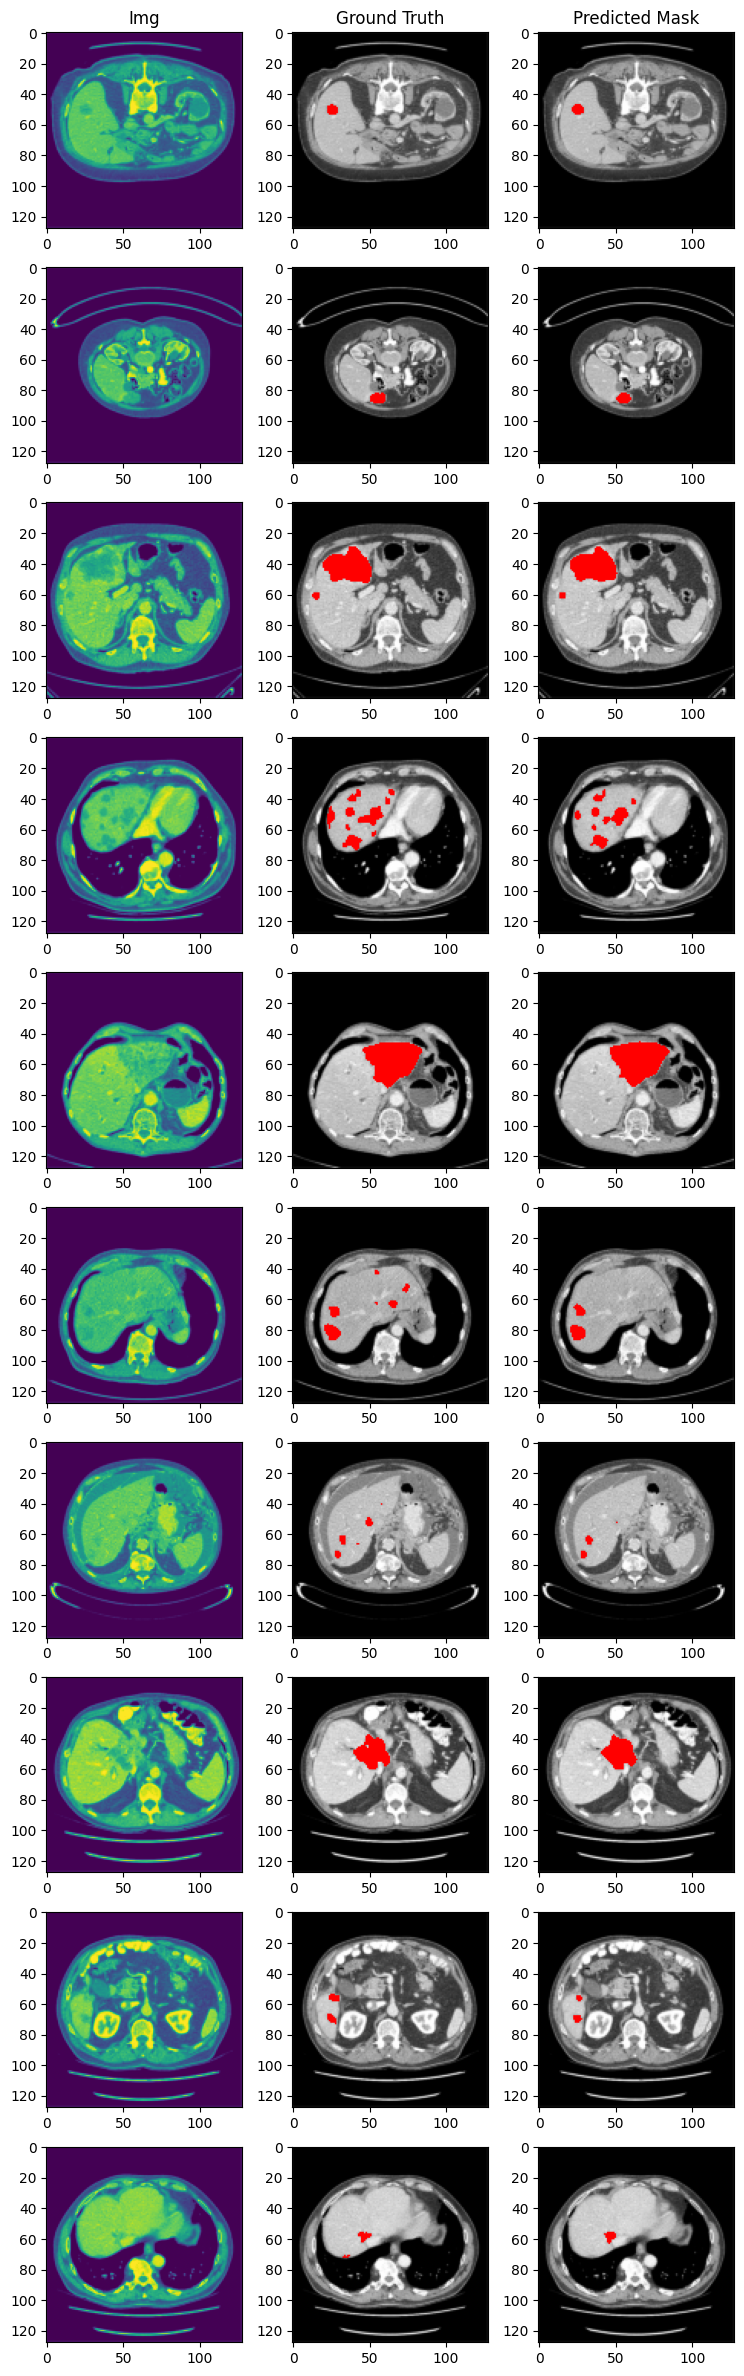

In [34]:
visualize_segmentation(
    model=TPUNetmodel,
    X=X,
    Y=Y,
    num_samples=10,
    seed=45,
    subfig_size=3
)